In [7]:
from gmm_denoiser import GMMDenoiser
from regularized_denoisers import denoise_l2
from skimage.restoration import denoise_wavelet
import wfdb
from utils import awgn, calc_snr
import matplotlib.pyplot as plt

%matplotlib inline

In [8]:
rec104 = wfdb.rdrecord("data/mit-bih-arrhythmia-database-1.0.0/104")
rec115 = wfdb.rdrecord("data/mit-bih-arrhythmia-database-1.0.0/115")

In [9]:
train_signals = [rec104.p_signal[:10800, 0]]

In [10]:
denoiser = GMMDenoiser(gmm_n_components=10, patch_size=30, train_signals=train_signals)
denoiser.fit()

In [11]:
test_signals = [
    rec115.p_signal[:512, 0],
    rec115.p_signal[512:1024, 0],
    rec115.p_signal[1024:1536, 0],
]

-10
-5
0
5
10


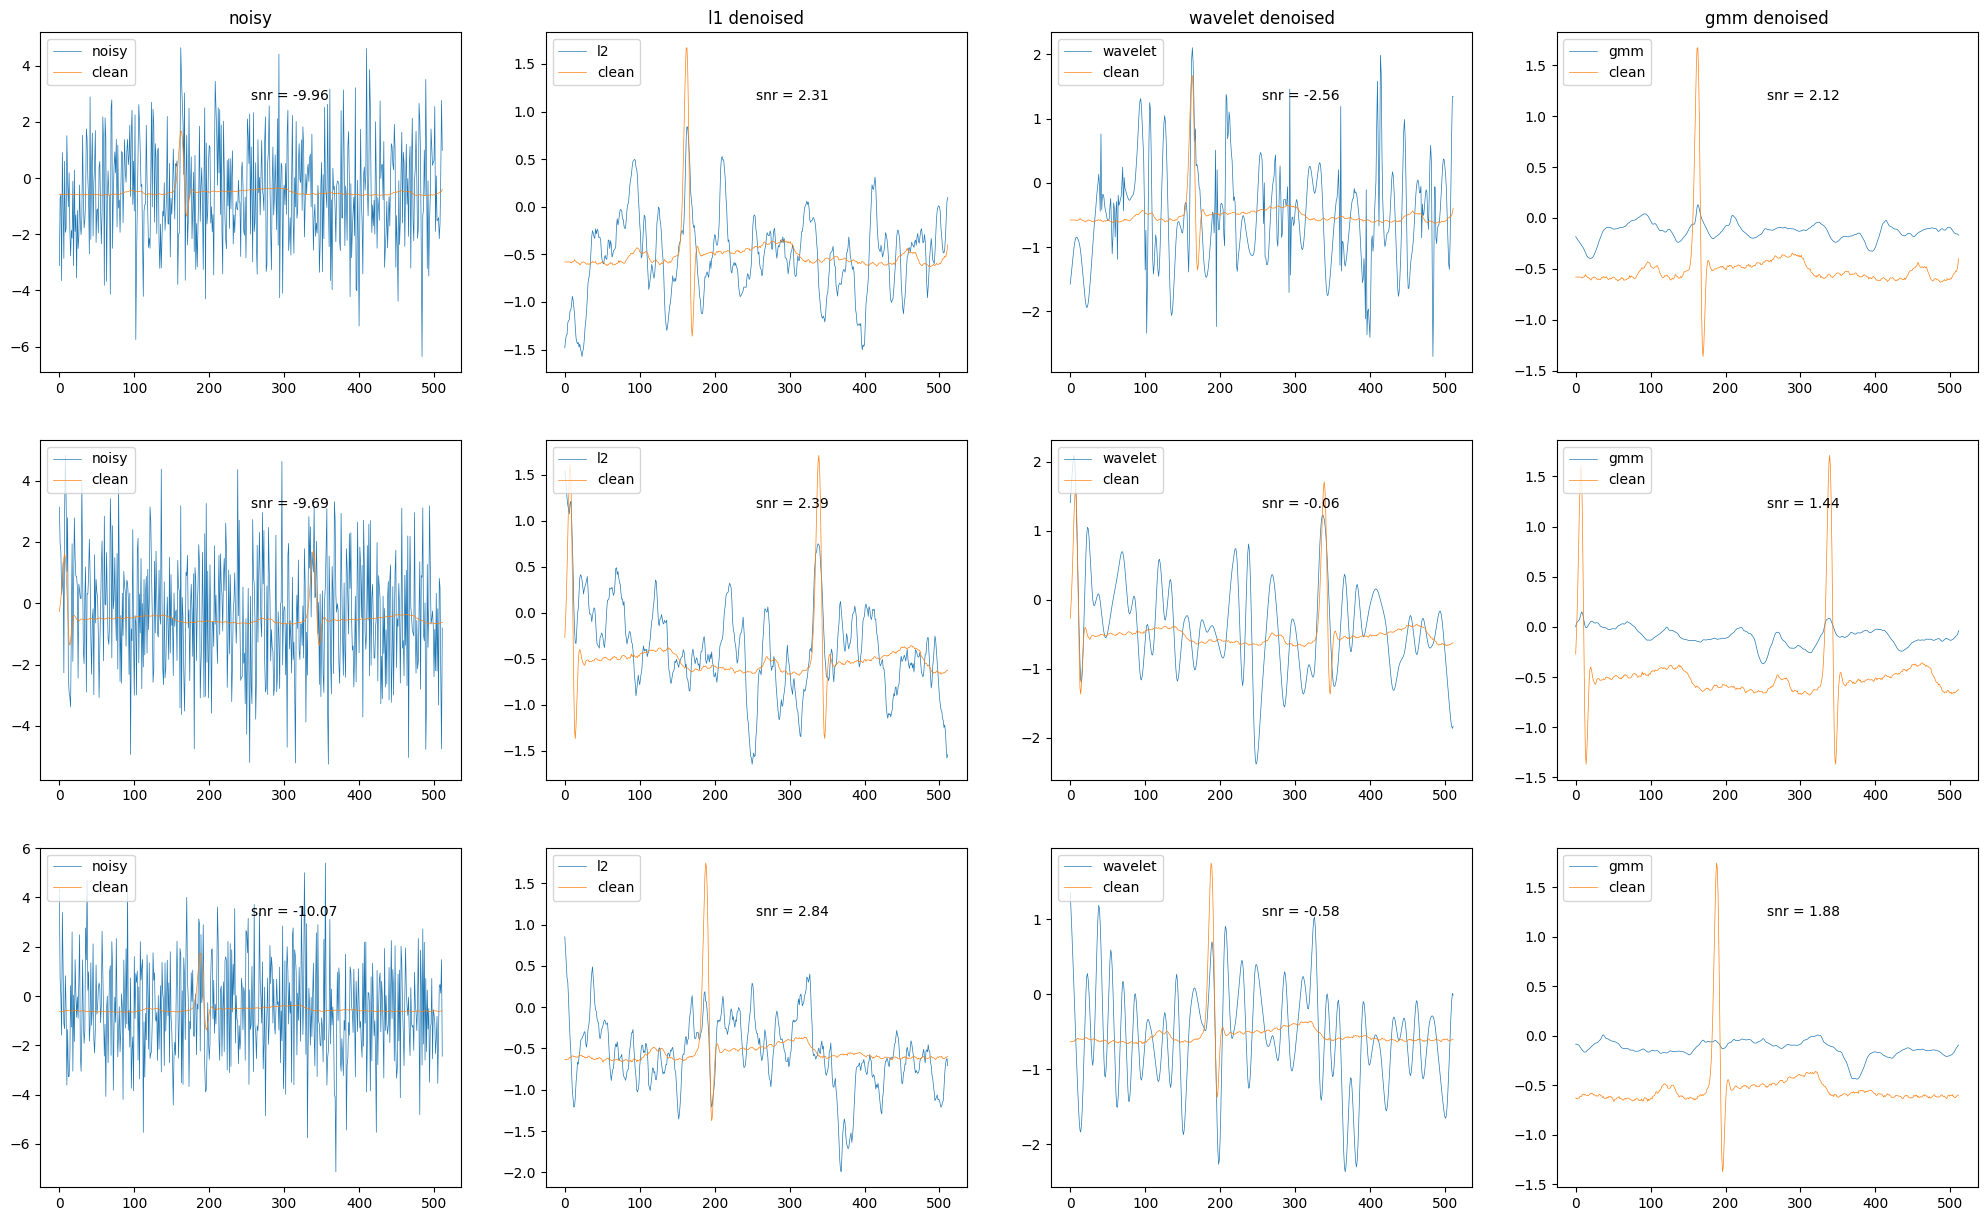

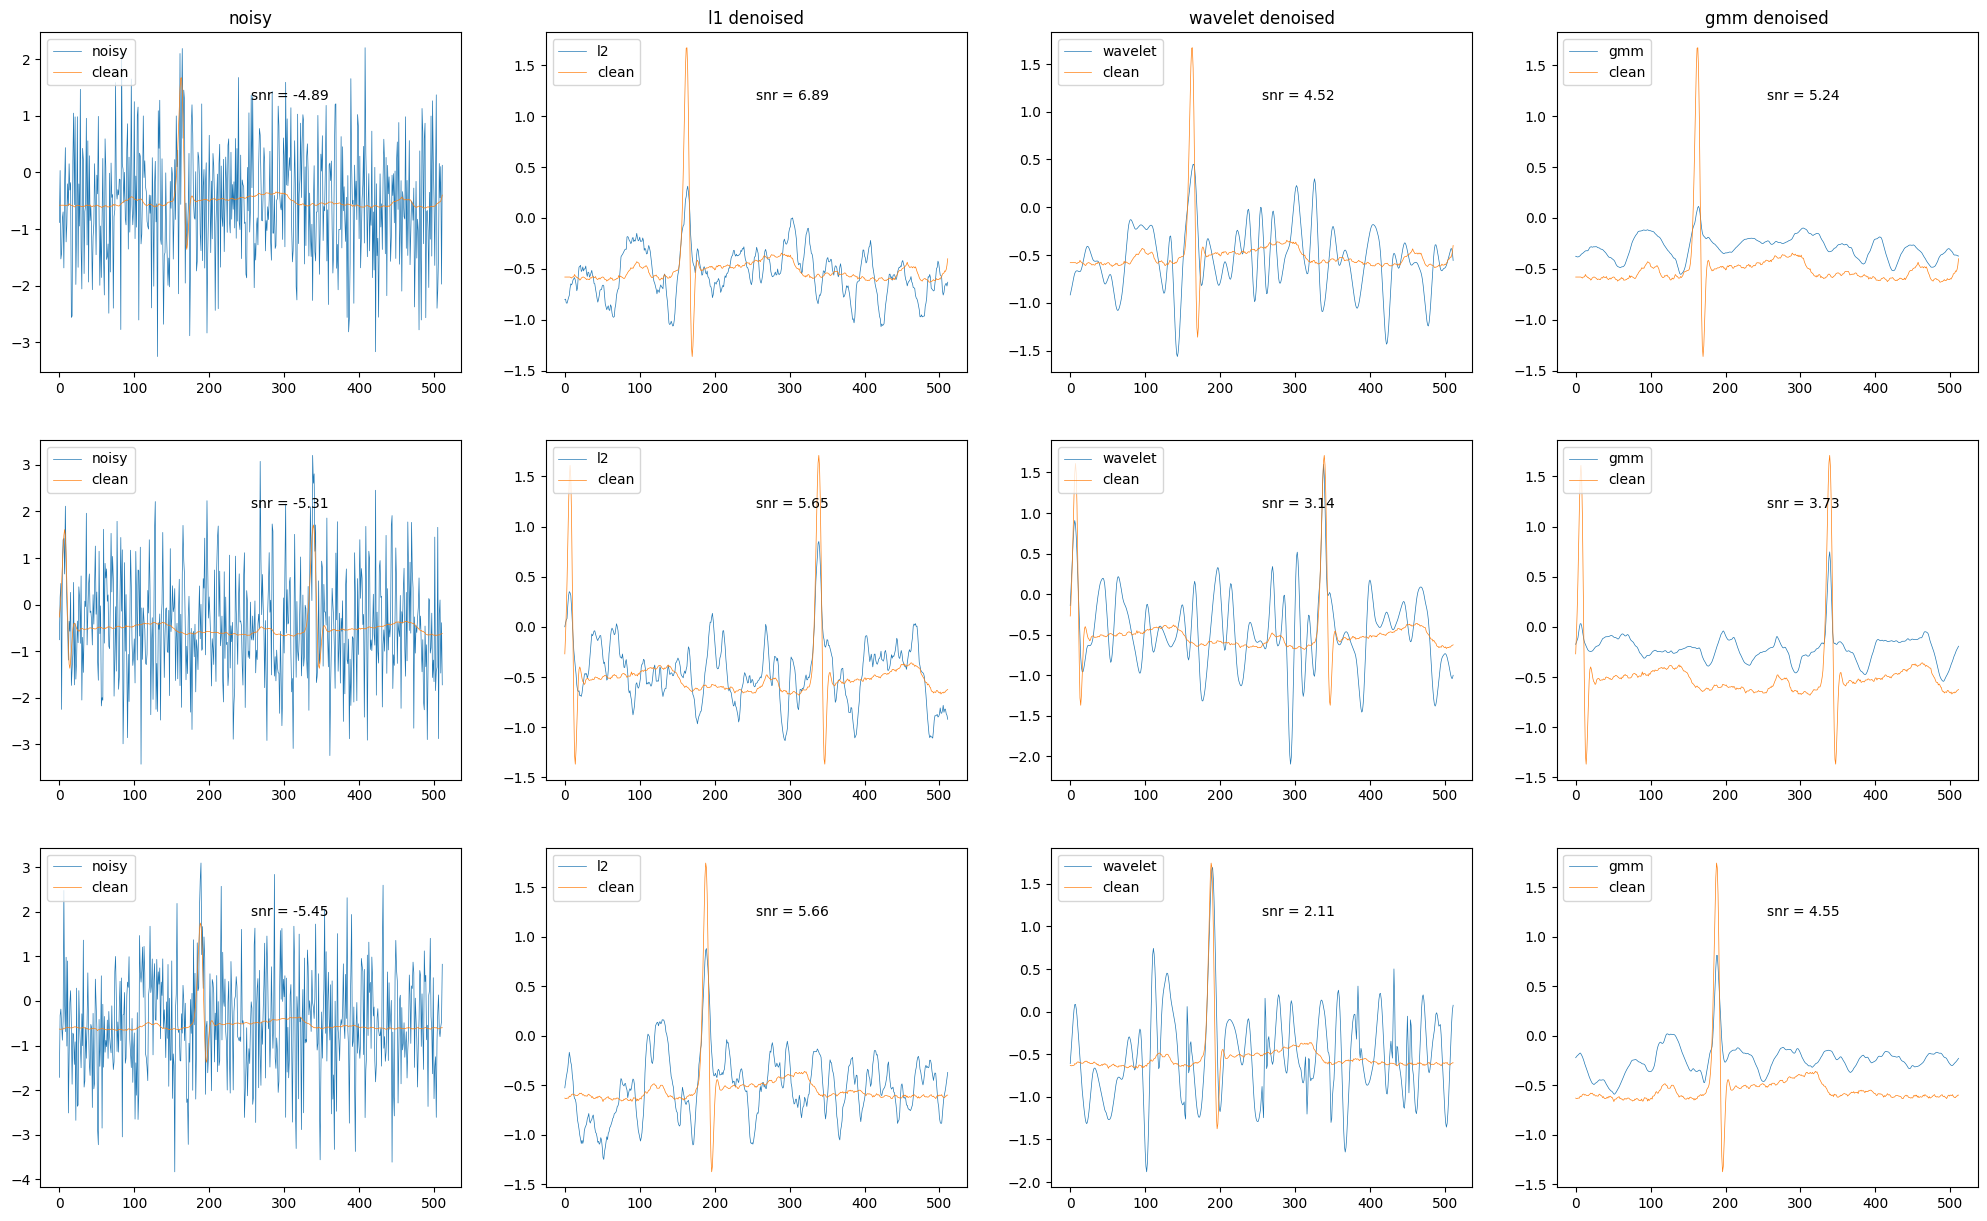

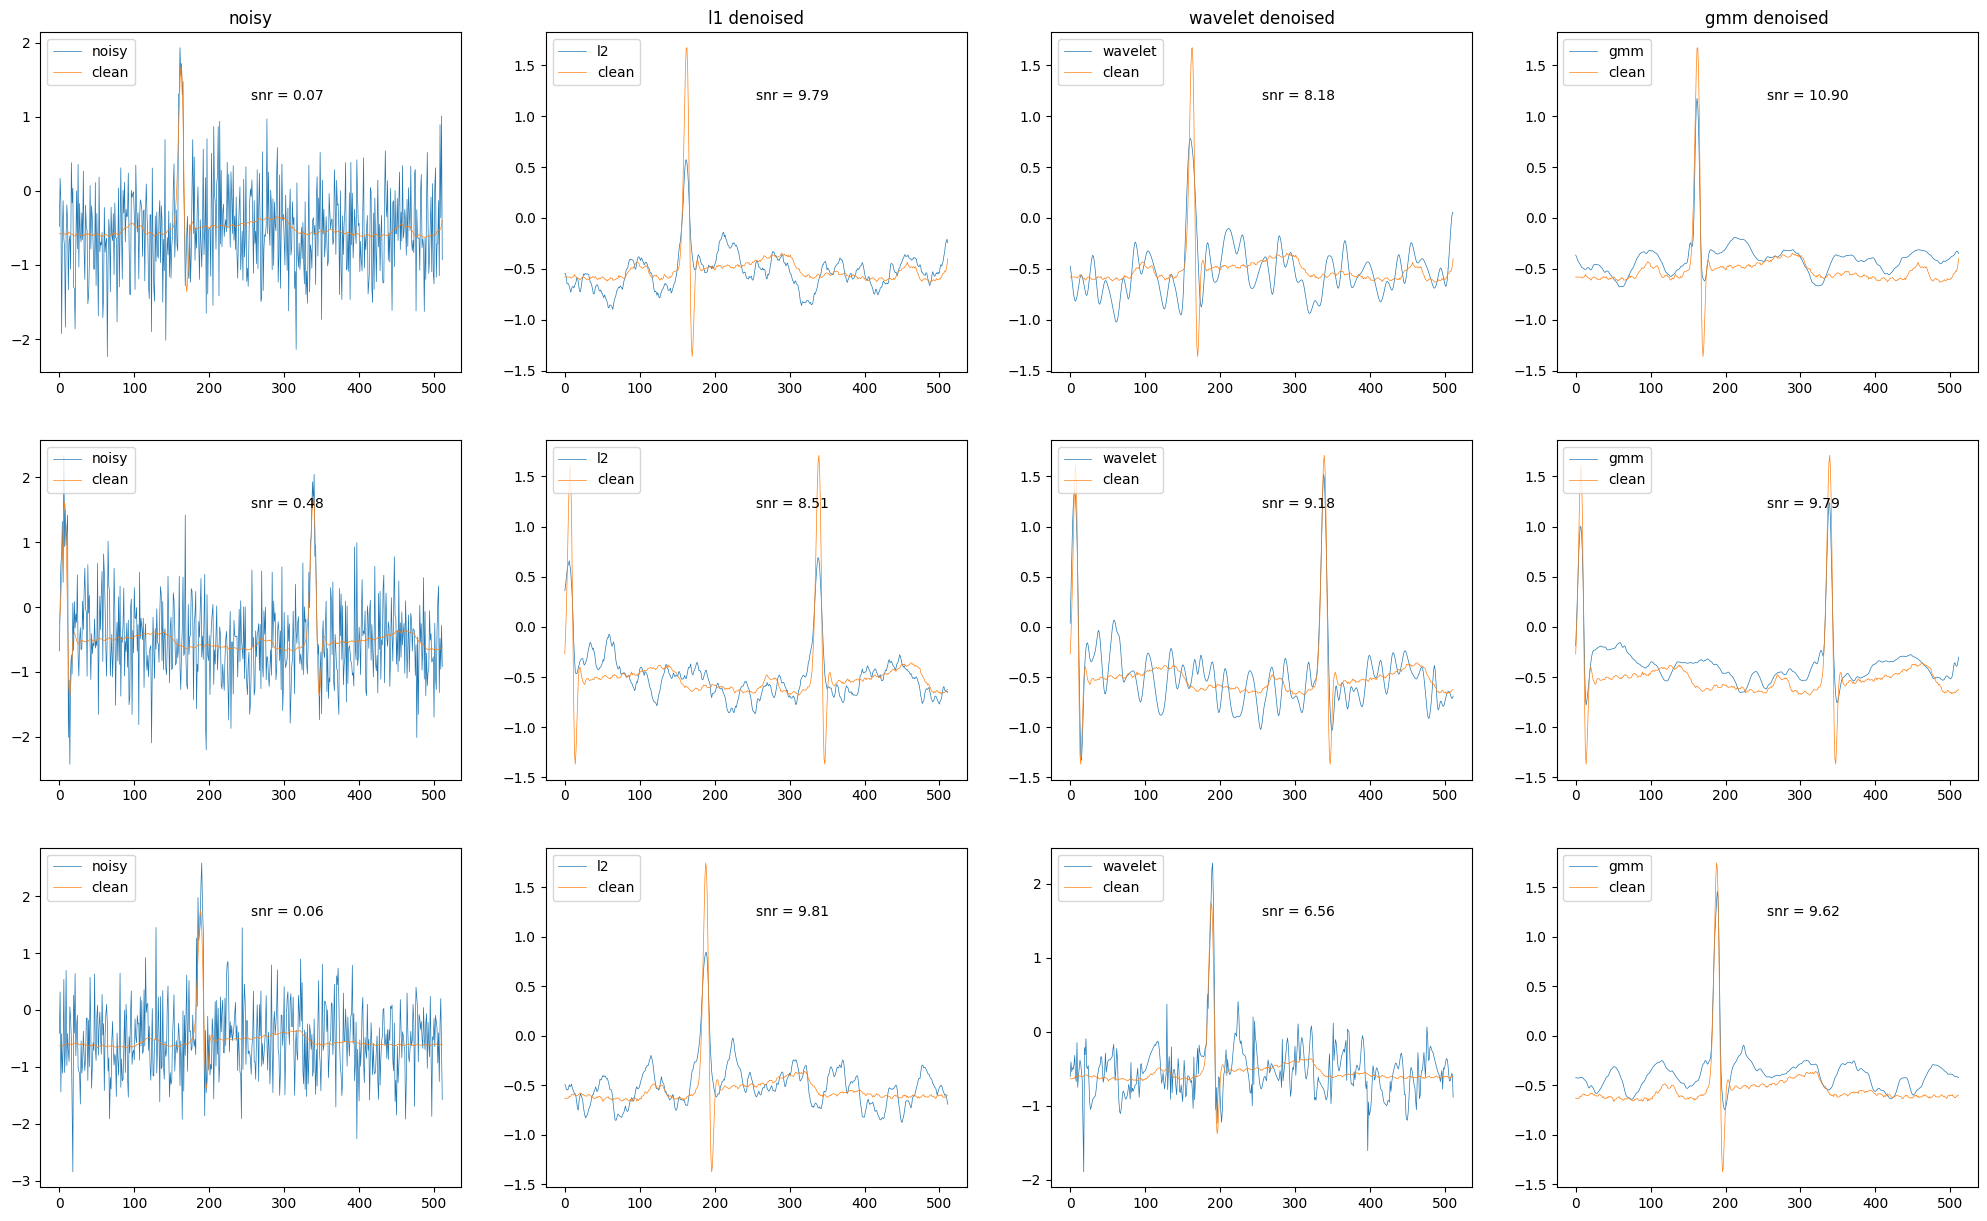

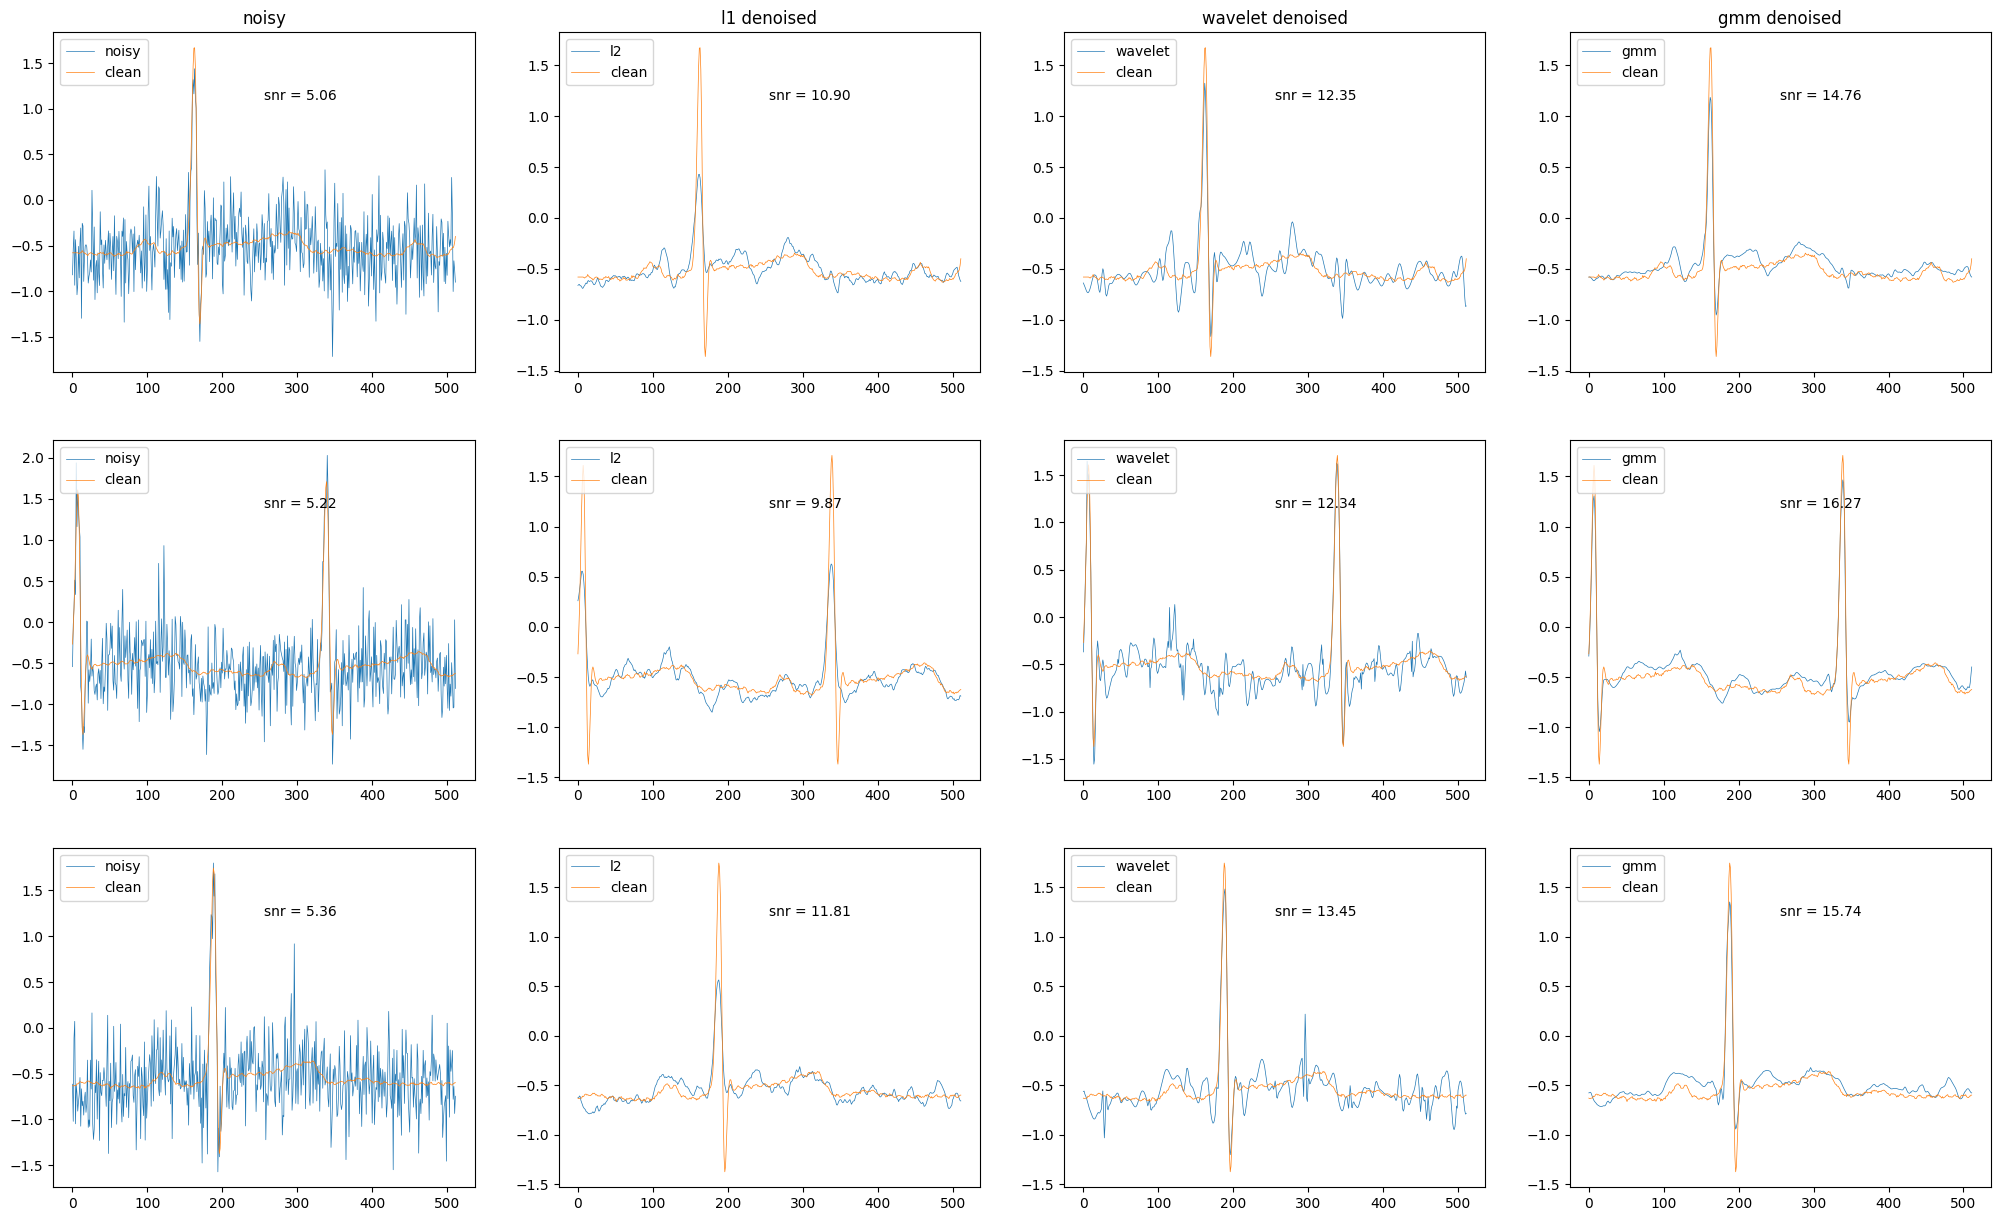

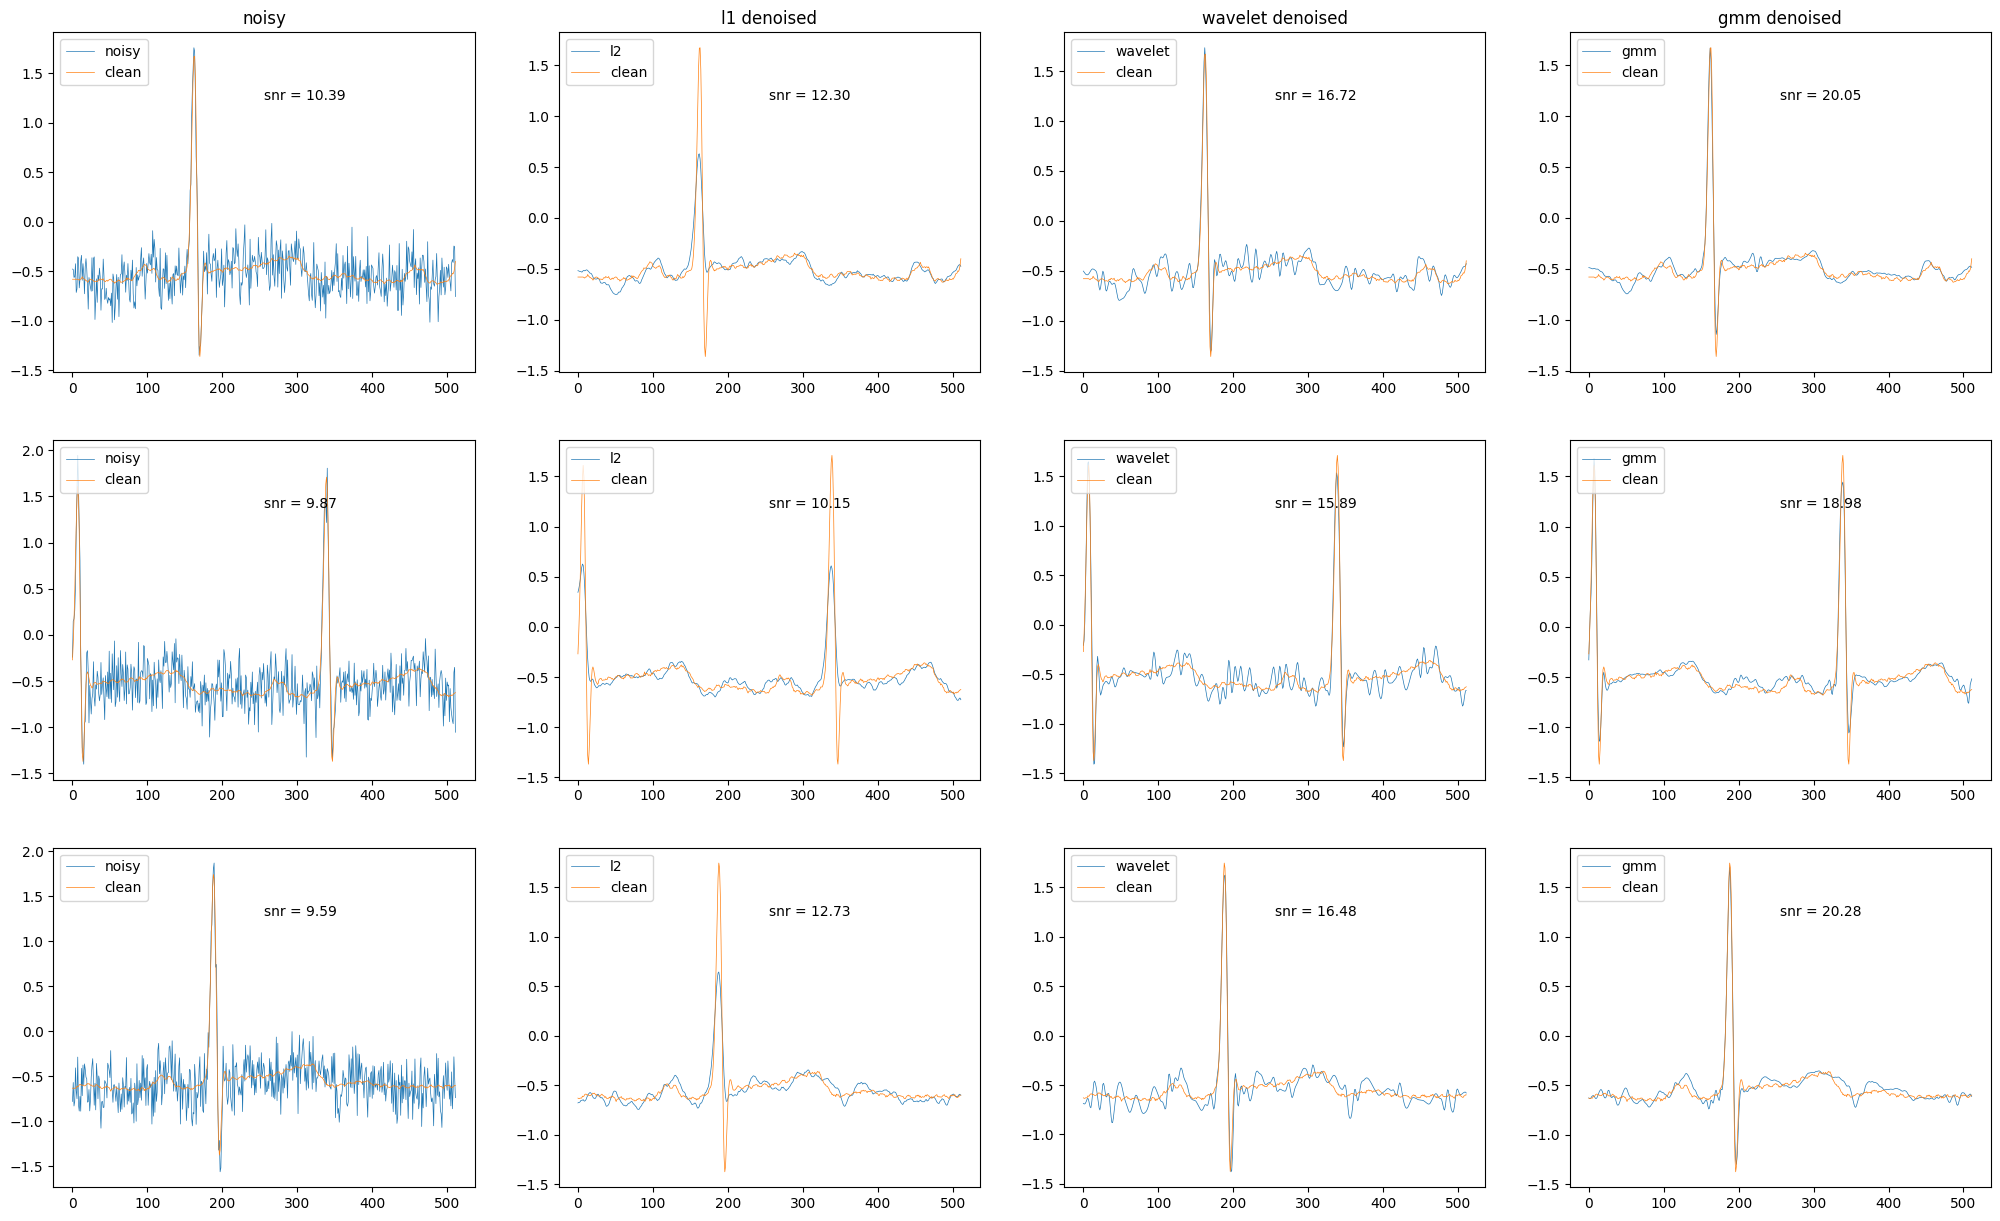

In [12]:
for snr_db in (-10, -5, 0, 5, 10):
    print(snr_db)
    fig, axs = plt.subplots(len(test_signals), 4, figsize=(25, 15))
    axs[0, 0].set_title("noisy")
    axs[0, 1].set_title("l1 denoised")
    axs[0, 2].set_title("wavelet denoised")
    axs[0, 3].set_title("gmm denoised")
    for i, nf in enumerate(test_signals):
        ns = awgn(nf, snr_db)
        nf_w_pred = denoise_wavelet(
            ns,
            method="BayesShrink",
            mode="soft",
            wavelet_levels=3,
            wavelet="sym8",
            rescale_sigma="True",
        )
        nf_l2_pred = denoise_l2(ns, K=20)
        nf_g_pred = denoiser.denoise(ns, snr_db_est=snr_db)

        ax1, ax2, ax3, ax4 = axs[i]

        ax1.plot(ns, linewidth=0.5, label="noisy")
        ax1.plot(nf, linewidth=0.5, label="clean")
        ax1.text(0.5, 0.8, f"snr = {calc_snr(nf, ns):.2f}", transform=ax1.transAxes)
        ax1.legend(loc="upper left")

        ax2.plot(nf_l2_pred, linewidth=0.5, label="l2")
        ax2.plot(nf, linewidth=0.5, label="clean")
        ax2.text(
            0.5, 0.8, f"snr = {calc_snr(nf, nf_l2_pred):.2f}", transform=ax2.transAxes
        )
        ax2.legend(loc="upper left")

        ax3.plot(nf_w_pred, linewidth=0.5, label="wavelet")
        ax3.plot(nf, linewidth=0.5, label="clean")
        ax3.text(
            0.5, 0.8, f"snr = {calc_snr(nf, nf_w_pred):.2f}", transform=ax3.transAxes
        )
        ax3.legend(loc="upper left")

        ax4.plot(nf_g_pred, linewidth=0.5, label="gmm")
        ax4.plot(nf, linewidth=0.5, label="clean")
        ax4.text(
            0.5, 0.8, f"snr = {calc_snr(nf, nf_g_pred):.2f}", transform=ax4.transAxes
        )
        ax4.legend(loc="upper left")

    fig.savefig(f"out/ecg_out/lwg,115,{snr_db}db.png")